# Imports

In [93]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize  
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.feature_extraction.text import TfidfVectorizer

# Data

In [94]:
fake = pd.read_csv("Fake.csv")
true = pd.read_csv("True.csv")

# Exploratory Data Analysis

### Number of True and Fake Articles

In [95]:
#Input: The length of the true and fake datasets
#Output: A bar chart that shows the number of true and fake articles in the datasets by their article type

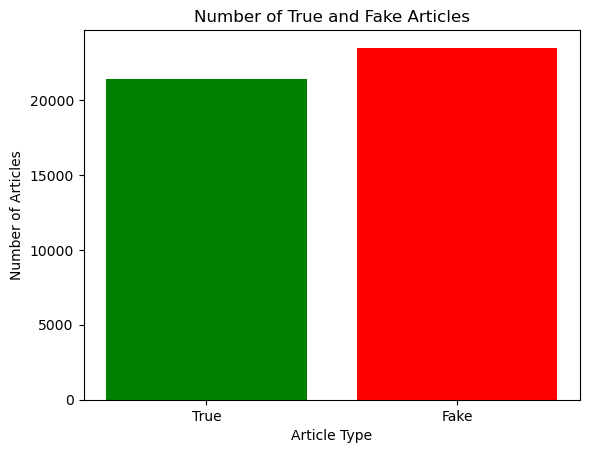

In [96]:
true_count = len(true)
fake_count = len(fake)
plt.bar(['True', 'Fake'], [true_count, fake_count], color=['green', 'red'])
plt.xlabel('Article Type')
plt.ylabel('Number of Articles')
plt.title('Number of True and Fake Articles')
plt.show()

### Average Number of Words in True and Fake Articles

In [97]:
#Input: The average of the number of words in true articles and the average of the number of words in fake articles 
#Output: A bar chart that shows the average number of words in true and fake articles based on their article type

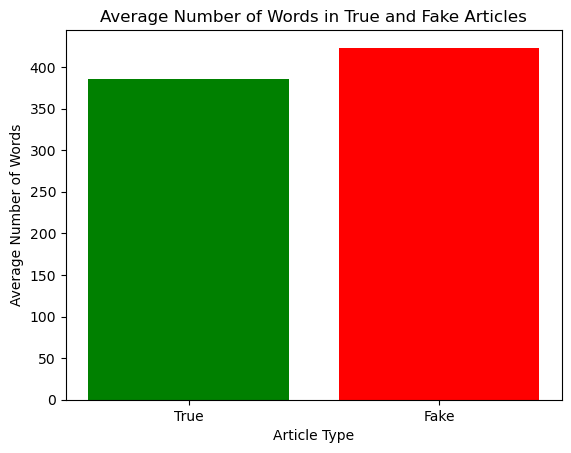

In [98]:
true_avg_length = true['text'].apply(lambda x:len(x.split())).mean()
fake_avg_length = fake['text'].apply(lambda x:len(x.split())).mean()
plt.bar(['True', 'Fake'], [true_avg_length, fake_avg_length], color=['green', 'red'])
plt.xlabel('Article Type')
plt.ylabel('Average Number of Words')
plt.title('Average Number of Words in True and Fake Articles')
plt.show()

# Data Cleaning

### Removing Pattern in True

In [99]:
#Input: The true csv file text column
#Output: Removing the dash in the true articles text from the text column. 

In [100]:
true['text'] = true.text.apply(lambda x:x.split("-",1)[1:])
true['text'] = true.text.apply(lambda x:str(x)[1:-1])

### Removing News Agency Names

In [101]:
#Input: The true and fake csv files text column 
#Output: All news agency names in the text column of the true and fake csv files are removed 

In [102]:
def remove_news_agency_name(text):
    return re.sub(r"Reuters|AP|New York Times|Washington Post|Business Insider|Atlantic|Fox News|National Review|Talking Points Memo|Buzzfeed News|Guardian|NPR|Vox|CNN|BBC|Bloomberg|Daily Mail|21st Century Wire|21st Century|Al Jazeera|21WIRE|ABC News", "", text)

In [103]:
true['text'] = true.text.apply(lambda x: remove_news_agency_name(x))
fake['text'] = fake.text.apply(lambda x: remove_news_agency_name(x))

### Combining Data

In [104]:
#Input: The true and fake csv files 
#Output: A combined csv file that contains both true and fake articles

In [105]:
true['label']=1
fake['label']=0
combined = pd.concat([true, fake], ignore_index=True, axis=0)

### Normalizing Text

In [106]:
#Input: The combined csv file text column
#Output: A combined csv file text column where the text of the articles are lowered and without punctuation 

In [107]:
combined['text'] = combined.text.apply(lambda x:x.lower())
combined['text'] = combined.text.apply(lambda x:re.sub(r'[^\w\s]+', ' ', x))

### Removing Stopwords

In [108]:
#Input: The combined csv file text column
#Output: A combined csv file where common words such as “the” or “a” are removed from the text column

In [109]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
def remove_stopwords(txt):
    no_stopwords = [word for word in txt.split() if word not in stop_words]
    return ' '.join(no_stopwords)
combined['text'] = combined['text'].apply(remove_stopwords)

[nltk_data] Downloading package stopwords to /Users/megsr/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Tokenizing

In [110]:
#Input: The combined csv file text column
#Output: A combined csv file where the words in the text column are in a comma separated list

In [111]:
nltk.download('punkt')
combined['text'] = combined.text.apply(lambda x:word_tokenize(x))

[nltk_data] Downloading package punkt to /Users/megsr/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Feature Extraction

### TfidfVectorize

In [112]:
#Input: The text column of the combined csv 
#Output: The vectorizer assigns a value to each word in the text column based on the frequency it appears in the 
#article which is stored in the variable txt_transformed

In [113]:
txt = combined.text.apply(lambda x: ' '.join(x))
tf = TfidfVectorizer(smooth_idf=False, sublinear_tf=False, norm=None, analyzer='word',max_features=200)
txt_fitted = tf.fit(txt)
txt_transformed = txt_fitted.transform(txt)

# Modeling

In [114]:
#Input: The combined csv 
#Output: A trained voting classifier model and accuracy score

### Voting Classifier w/ TfidfVectorize

In [115]:
X_train, X_test, y_train, y_test = train_test_split(txt_transformed,combined['label'], test_size=0.2, random_state=42)
vc = VotingClassifier([('lr', LogisticRegression()), ('dt', DecisionTreeClassifier()), ('rf', RandomForestClassifier()), ('svc', SVC()), ('ada', AdaBoostClassifier()), ('gb', GradientBoostingClassifier())])
vc.fit(X_train, y_train)
vc_pred = vc.predict(X_test)
accuracy = accuracy_score(y_test, vc_pred)
print('accuracy:', accuracy)

accuracy: 0.9638084632516704


# Testing

## Manually Collected Dataset

In [116]:
manual_dataset = pd.read_csv("manual_dataset.csv", index_col=0)

### Preprocessing

In [117]:
#Input: The manually collected dataset text column 
#Output: A text column that is normalized, tokenized, and does not have stopwords

In [118]:
manual_dataset['Text'] = manual_dataset.Text.apply(lambda x: remove_news_agency_name(str(x)))

In [119]:
manual_dataset['Text'] = manual_dataset.Text.apply(lambda x:str(x))
manual_dataset['Text'] = manual_dataset.Text.apply(lambda x:x.lower())
manual_dataset['Text'] = manual_dataset.Text.apply(lambda x:re.sub(r'[^\w\s]+', ' ', x))
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
def remove_stopwords(txt):
    no_stopwords = [word for word in txt.split() if word not in stop_words]
    return ' '.join(no_stopwords)
manual_dataset['Text'] = manual_dataset['Text'].apply(remove_stopwords)
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /Users/megsr/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/megsr/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

### TF-IDF Vectorizing and Application

In [120]:
#Input: The text column of the manually collected dataset 
#Output: Whether an article is true or fake based on the model

In [121]:
txt_transformed = tf.transform(manual_dataset["Text"])
arr = vc.predict(txt_transformed)
arr_list = list(arr)

### Results

In [122]:
manual_dataset['random_forest_results']=arr_list
count_true_values = ((manual_dataset['Real_Fake'] == 'Real') & (manual_dataset['random_forest_results'] == 1) | 
                     (manual_dataset['Real_Fake'] == 'Fake') & (manual_dataset['random_forest_results']  == 0)).sum()

print("How many artcles our model correctly predicted:", count_true_values)
print("How many artcles our model incorrectly predicted:", 30-count_true_values)
manual_dataset

How many artcles our model correctly predicted: 23
How many artcles our model incorrectly predicted: 7


,Real_Fake,News Source,Link,Date,Topic/ Keyword (if applicable),Title,Text,random_forest_results
#,,,,,,,,
0,Real,The Globe and Mail,https://www.theglobeandmail.com/business/comme...,2/19/2024,Renewable energy,"With Alberta renewables ban, business common s...",investment creates jobs expands tax revenue pr...,1
1,Real,CBC News,https://www.cbc.ca/news/canada/calgary/oil-ind...,2/22/24,Oil,Some sectors of oil industry 'dragging their h...,prime minister justin trudeau alberta premier ...,1
2,Real,CBC News,https://www.cbc.ca/news/canada/thunder-bay/cat...,03/04/24,Mining,"Demanding a proper say, Cat Lake First Nation'...",cat lake first nation granted injunction pausi...,1
3,Real,CBC News,https://www.cbc.ca/news/politics/guilbeault-no...,02/14/24,Climate,Feds will stop investing in 'large' road proje...,environment minister steven guilbeault said mo...,1
4,Real,Global News,https://globalnews.ca/news/10292216/climate-ch...,02/13/2024,Climate,Floods and fires: Climate change brings health...,communities across british columbia needs prep...,1
5,Real,CBC News,https://www.cbc.ca/news/canada/toronto/ontario...,02/08/24,Climate,New mineral processing plants touted as 'missi...,canadian mining company announce plans thursda...,1
6,Real,Financial Post,https://financialpost.com/pmn/business-pmn/inf...,03/04/24,Climate,Infernos Rage From Texas to Australia as Fire ...,year deadly wildfires around globe world burni...,1
7,Real,CBC News,https://www.cbc.ca/news/canada/saskatchewan/sa...,03/05/24,Climate,Sask. farmer 'breathing a sigh of relief' afte...,saskatchewan farmer says thrilled snowfall wee...,1
8,Real,CBC News,https://www.cbc.ca/news/canada/british-columbi...,03/03/24,Wildfire,Inaccurate government data may be stoking wild...,wildfire fighting forest management decisions ...,0
